In [1]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
import PIL.Image as Image
from torch.utils.data import DataLoader
# from vj_RAnet_models import Full_training_RAnet
torch.cuda.device_count()
from torch.utils.data import DataLoader
from vj_loss_functions import *
from vj_data_transform import *
from vj_davis_17_loader import Custom_DAVIS2017_dataset
from torch.utils.data import DataLoader

In [2]:
net_name = 'RANet'
parser = argparse.ArgumentParser(description='RANet')
parser.add_argument('--deviceID', default=[0], help='device IDs')
parser.add_argument('--threads', type=int, default=16, help='number of threads for data loader to use')
parser.add_argument('--workfolder', default='../models/')
parser.add_argument('--savePName', default=net_name)
parser.add_argument('--net_type', default='single_object')
parser.add_argument('--fp16', default=True)
print('===> Setting ......')
# opt = parser.parse_args()
class args:
    pass
opt = args()
# opt.deviceID = [0]
opt.threads=0
opt.workfolder='../models/'
opt.savePName = net_name
opt.net_type='single_object'
opt.fp16=False

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

try:
    os.mkdir(opt.workfolder)
    print('build working folder: ' + opt.workfolder)
except:
    print(opt.workfolder + 'exists')


print('===> Building model')
############## Choose a model #################
# params='RANet_video_multi.pth'
# params='RANet_encoder_retrain_epoch1.pth'
# params='RANet_multi_basic_train_epoch1.pth'
params = 'RANet_video_multi.pth'

dataset='17train'
save_root='../predictions/RANet_Video_17val'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpus = [i for i in range(torch.cuda.device_count())]
# gpus = [0]
print('using GPUs ID: {}'.format(gpus))

model = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864
if dataset in ['16val', '16trainval', '16all']:
    model.set_type('single_object')
    year = '2016'
elif dataset in ['17val', '17test_dev', '17train']:
    model.set_type('multi_object')
    year = '2017'
else:
    assert('dataset error')
checkpoint_load(opt.workfolder + params, model)

root = '../datasets/DAVIS'
img_mode = '480p'
img_shape = (inSize1,inSize2)

===> Setting ......
../models/exists
===> Building model
using GPUs ID: [0]
Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_video_multi.pth'


In [3]:
trnsfm_crop = RandomCrop(min_size=0.75, prob=0.3)
trnsfm_rotate=RandomRotate(max_angle=np.pi/6, prob=0.3)
trnsfm_flip=RandomFlip(vprob=0.2, hprob=0.2)
#transforms.Compose([trnsfm_crop,trnsfm_rotate,trnsfm_flip])

trnsfm_piecewise = transforms.Compose([trnsfm_crop,trnsfm_rotate]) 
trnsfm_common = transforms.Compose([trnsfm_flip])
get_prev_mask = True
use_std_template = True

img_dataset = Custom_DAVIS2017_dataset(root=root, img_shape=img_shape, img_mode=img_mode,\
                            get_prev_mask=get_prev_mask, use_std_template=use_std_template,\
                            trnsfm_common = None, trnsfm_piecewise=None,loader_type='val')

loading files from:  ../datasets/DAVIS/ImageSets/2017/val.txt


In [4]:
model2 = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864

model2.set_type('multi_object')
#RANet_multi_IOU_loss_train_encoder_finetuned_epoch1
#RANet_multi_IOU_loss_train_not_encoder_epoch1.pth
#RANet_video_multi
#RANet_video_multi_BCE_epoch1.pth
checkpoint_load(opt.workfolder + 'RANet_video_multi.pth', model2)
scale_factor2 = 0
model2.cuda()
model2.eval()
print("model2 ready")

checkpoint_load(opt.workfolder + 'RANet_video_multi_BCE_epoch3.pth', model)
scale_factor1 = 0.5
model.cuda()
model.eval()
print("model ready")

Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_video_multi.pth'
model2 ready
=> Loaded checkpoint '../models/RANet_video_multi_BCE_epoch3.pth'
model ready


In [17]:
#RANet_video_multi_BCE_trnsfm_best_epoch0.pth
#RANet_video_multi.pth
#RANet_video_multi_IOU_trnsfm_disc_scale05_epoch0_best.pth
#RANet_video_multi_IOU_best_model.pth
checkpoint_load(opt.workfolder + 'RANet_video_multi.pth', model)
disc_scale = 0
model.cuda()
model.eval()
checkpoint_load(opt.workfolder + 'RANet_video_multi_IOU_best_model.pth', model2)
disc_scale2 = 0
model2.cuda()
model2.eval()
print("models ready")

=> Loaded checkpoint '../models/RANet_video_multi.pth'
=> Loaded checkpoint '../models/RANet_video_multi_IOU_best_model.pth'
models ready


In [9]:
img_dataset.names

['bike-packing',
 'blackswan',
 'bmx-trees',
 'breakdance',
 'camel',
 'car-roundabout',
 'car-shadow',
 'cows',
 'dance-twirl',
 'dog',
 'dogs-jump',
 'drift-chicane',
 'drift-straight',
 'goat',
 'gold-fish',
 'horsejump-high',
 'india',
 'judo',
 'kite-surf',
 'lab-coat',
 'libby',
 'loading',
 'mbike-trick',
 'motocross-jump',
 'paragliding-launch',
 'parkour',
 'pigs',
 'scooter-black',
 'shooting',
 'soapbox']

In [21]:
def get_corr_masks(self, template, target, template_msk, target_msk, prev_mask = None,disc_scale=0):

    
    # Exact template features
    x2 = template
    base_features2 = self.res_forward(x2)
    Kernel_3 = F.normalize(F.max_pool2d(self.L3(base_features2[2]), 2))
    Kernel_4 = F.normalize(self.L4(base_features2[3]))
    Kernel_5 = F.normalize(F.interpolate(self.L5(base_features2[4]), scale_factor=2, mode='bilinear'))
    Kernel_tmp = F.normalize(self.L_g(torch.cat([Kernel_3, Kernel_4, Kernel_5], dim=1)))
#             Kernel_tmp = f.avg_pool2d(Kernel_tmp, 2)

    # Current frame feature
    base_features1 = self.res_forward(target)
    Feature_3 = F.normalize(F.max_pool2d(self.L3(base_features1[2]), 2))
    Feature_4 = F.normalize(self.L4(base_features1[3]))
    Feature_5 = F.normalize(F.interpolate(self.L5(base_features1[4]), scale_factor=2, mode='bilinear'))
    Feature = F.normalize(self.L_g(torch.cat([Feature_3, Feature_4, Feature_5], dim=1)))

    Out_Rs = []

    basef1 = torch.cat([self.ls13(base_features1[2]),
                        self.ls14(base_features1[3]),
                        self.ls15(base_features1[4]), ], 1)
    basef2 = torch.cat([self.ls22(base_features1[1]),
                        self.ls23(base_features1[2]),
                        self.ls24(base_features1[3]), ], 1)
    basef3 = torch.cat([self.ls31(base_features1[0]),
                        self.ls32(base_features1[1]),
                        self.ls33(base_features1[2])], 1)
    corr_f_outs = []
    corr_b_outs = []
    idx = 0  # batch
    
    # For storing and using intermediate features
    Feat_images_list =[]
    feat_per_img = []
    
    ker = Kernel_tmp[idx: idx + 1]
    feature = Feature[idx: idx + 1]
    m2 = template_msk[idx: idx + 1]

    if (prev_mask is not None):
        mp = prev_mask[idx:idx+1]
    else:
        mp = template_msk[idx: idx + 1]

    max_obj = m2.max().int().data.cpu().numpy()
    if max_obj < 2:
        m2[0, 0, 0, 0] = 2
        max_obj = m2.max().int().data.cpu().numpy()
    M2s = self.P2masks(F.relu(m2 - 1), max_obj - 1)
#             M2_all = m2.ge(1.5).float()
    Mps = self.P2masks(F.relu(mp - 1), max_obj - 1)
#             Mp_all = mp.ge(1.5).float()

    # Correlation
    W0, H0 = ker.size()[-2::]
    W,H = feature.size()[-2::]

#             Corr_subs = []
    ker_R = self.to_kernel(ker)
    corr_R = self.correlate(ker_R, feature)
    template_corr = self.correlate(ker_R, ker) # Size W0xH0xW0*H0

    # Ranking attention scores
    T_corr = F.max_pool2d(corr_R, 2).view(-1, W0*H0, W*H//4).transpose(1, 2).view(-1,  W*H//4, W0, H0)
    R_map = F.relu(self.Ranking(T_corr)) * 0.2

    Outs = []
    for idy in range(1, max_obj):  # training:with_bg, testing: w/o BG
        feat_per_obj = []
        
        m2_rep = F.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
        corr = m2_rep.view(m2_rep.size()[0], -1, 1, 1) * corr_R
        co_size = corr.size()[2::]
        max_only, indices = F.max_pool2d(corr, co_size, return_indices=True)
        max_only = max_only.view(-1, 1, W0*H0) + (R_map * m2_rep).view(-1, 1, W0*H0)


        # Find correlation of a template FB pixel with other FB/BG pixels.
        # For more correlation to FB pixel, +ve score, and -ve score for BG correlation
        # For each pixel, take top 9 similar pixels
        pixel_cnt = 9
        temp_corr = template_corr * m2_rep.view(1,W0*H0,1,1)
        FG_disc_score = (temp_corr*m2_rep).reshape(1,W0*H0,W0*H0)
        FG_disc_score, _ = FG_disc_score.sort(descending=True,dim=2)
        FG_disc_score = FG_disc_score[:,:,:pixel_cnt]
        FG_disc_score = FG_disc_score.sum(dim=2)/(pixel_cnt)

        FG_neg_score = (temp_corr*(1-m2_rep)).reshape(1,W0*H0,W0*H0)
        FG_neg_score, _ = FG_neg_score.sort(descending=True, dim=2)
        FG_neg_score = FG_neg_score[:,:,:pixel_cnt]
        FG_neg_score = FG_neg_score.sum(dim=2)/(pixel_cnt)
        FG_disc_score -= FG_neg_score/2

        max_only = max_only + FG_disc_score.view(-1,1,W0*H0)*disc_scale
        ###################### Done discriminant score for FG

        if self.apply_nms:
            max_only = nms_excitation(max_only, window_size=1)
        ###################### NMS excitation applied if needed

        # Rank & select FG
        m_sorted, m_sorted_idx = max_only.sort(descending=True, dim=2)
        corr = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr, m_sorted_idx)])
        
#         corr[128:] = corr[128:]*0 #+ 0.960 + torch.rand((256,30,54)).cuda()*0.01
        # Merge net FG
        corr_fores = self.p_2(self.res_1(self.p_1(F.interpolate(corr, scale_factor=2, mode='bilinear'))))
        
        # Store best fg corr for this object
        corr_f_outs.append((corr, m_sorted_idx))
        
        if max_obj == 1:  # only bg
            print('missing obj')
            corr_backs = torch.zeros(corr_fores.size()).cuda()
        else:

            m2_rep = F.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
            corr_b = (1-m2_rep.view(m2_rep.size()[0], -1, 1, 1) )* corr_R
            R_map_b = (R_map * (1-m2_rep)).view(-1, 1, W0*H0)
            ########## Above added by VJ ###########

            max_only_b, indices = F.max_pool2d(corr_b, co_size, return_indices=True)
            max_only_b = max_only_b.view(-1, 1, W0*H0) + R_map_b ###

            # Find correlation of a template BG pixel with other FB/BG pixels.
            # For more correlation to BG pixel, +ve score, and -ve score for FG correlation
            # For each pixel, take top 9 similar pixels
            temp_corr = template_corr * (1-m2_rep.view(1,W0*H0,1,1))
            BG_disc_score = (temp_corr*(1-m2_rep)).reshape(1,W0*H0,W0*H0)
            BG_disc_score, _ = BG_disc_score.sort(descending=True, dim=2)
            BG_disc_score = BG_disc_score[:,:,:pixel_cnt]
            BG_disc_score = BG_disc_score.sum(dim=2)/(pixel_cnt)

            BG_neg_score = (temp_corr*m2_rep).reshape(1,W0*H0,W0*H0)
            BG_neg_score, _ = BG_neg_score.sort(descending=True, dim=2)
            BG_neg_score = BG_neg_score[:,:,:pixel_cnt]
            BG_neg_score = BG_neg_score.sum(dim=2)/(pixel_cnt)
            BG_disc_score -= BG_neg_score/2
            max_only_b = max_only_b + BG_disc_score.view(-1,1,W0*H0)*disc_scale
            ###################### Done discriminant score for BG

            if self.apply_nms:
                max_only = nms_excitation(max_only_b, window_size=1)
            ###################### NMS excitation applied if needed

            # Rank & select BG
            m_sorted, m_sorted_idx = max_only_b.sort(descending=True, dim=2)
            corr_b = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr_b, m_sorted_idx)])
            # Merge net BG
            corr_backs = self.p_2(self.res_1(self.p_1(F.interpolate(corr_b, scale_factor=2, mode='bilinear'))))
            
            # Store best bg corr for this object
            corr_b_outs.append((corr_b, m_sorted_idx))
        if idy == 0:
            tmp = corr_fores
            corr_fores = corr_backs
            corr_backs = tmp
            print("Don't come here!!!2")
            m_p = F.adaptive_avg_pool2d(Mp_all, corr_fores.size()[-2::])
        else:
            m_p = F.adaptive_avg_pool2d(Mps[idy], corr_fores.size()[-2::])
        
        base1 = torch.cat([basef1[idx: idx + 1], corr_fores, corr_backs, m_p], 1)
        fea1 = self.R1(base1)
        feat_per_obj.append(fea1)
        
        base2 = torch.cat([basef2[idx: idx + 1],
                           fea1], 1)
        fea2 = self.R2(base2)
        feat_per_obj.append(fea2)
        
        base3 = torch.cat([basef3[idx: idx + 1],
                           fea2], 1)
        fea3 = self.R3(base3)
        out = torch.sigmoid(fea3)
        feat_per_img.append(feat_per_obj)
    Feat_images_list.append(feat_per_img)
    return corr_f_outs, corr_b_outs, Feat_images_list

In [41]:

file_index = 0
while(img_dataset.names[file_index] != 'india'):
    file_index += 1
    if (file_index > 30):
        print("file not found, breaking")
        break

name = img_dataset.names[file_index]
img_counter = 30
img_dataset.img_counter[name] = img_counter
target_img = Image.open(img_dataset.video_files[name][img_counter][0])

template,template_mask, target,target_mask, prev_mask = img_dataset.__getitem__(file_index)
template = template.cuda().unsqueeze(0)
template_mask = template_mask.cuda().unsqueeze(0)
target = target.cuda().unsqueeze(0)
target_mask = target_mask.cuda().unsqueeze(0)
prev_mask = prev_mask.cuda().unsqueeze(0)

with torch.no_grad():
    corr_f, corr_b, Feat_images_list = get_corr_masks(model, template=template,target=target,\
            template_msk=template_mask, target_msk = None,prev_mask=prev_mask, disc_scale=disc_scale)    
    corr_f2, corr_b2, Feat_images_list2 = get_corr_masks(model2, template=template,target=target,\
            template_msk=template_mask, target_msk = None,prev_mask=prev_mask, disc_scale=disc_scale2)  

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Text(0.5, 1.0, 'The Target object')

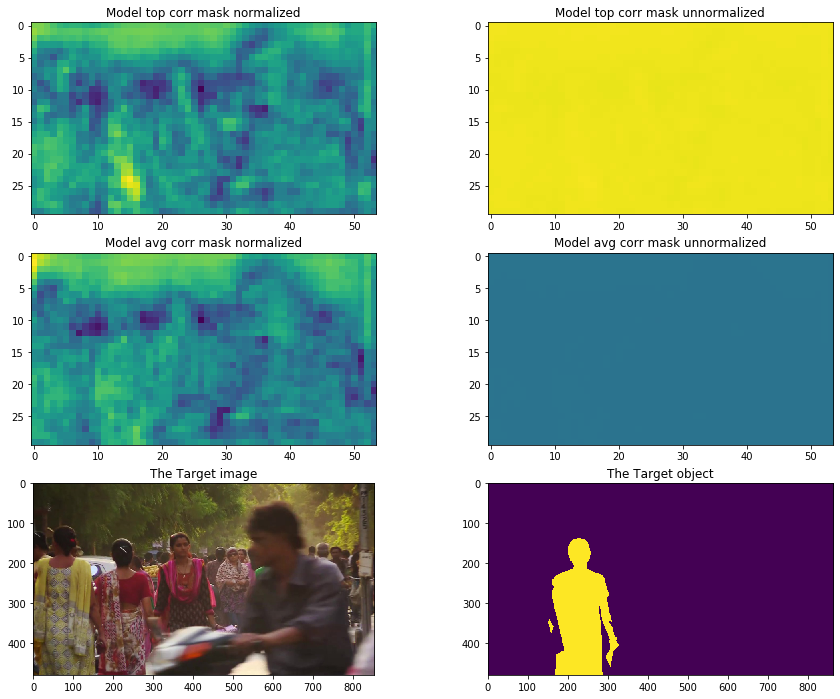

In [42]:
obj = 1
f_id = 0
map1 = corr_f[obj][0][0,f_id].detach().cpu().numpy()
map1_avg = corr_f[obj][0][0].mean(dim=0).detach().cpu().numpy()

plt.figure(figsize=(15,12))
ax = plt.subplot(3,2,1)
ax.imshow(map1)#, vmin=0, vmax=1)
plt.title("Model top corr mask normalized")
ax = plt.subplot(3,2,2)
ax.imshow(map1, vmin=0, vmax=1)
plt.title("Model top corr mask unnormalized")
ax = plt.subplot(3,2,3)
ax.imshow(map1_avg)#, vmin=0, vmax=1)
plt.title("Model avg corr mask normalized")
ax = plt.subplot(3,2,4)
ax.imshow(map1_avg, vmin=0, vmax=1)
plt.title("Model avg corr mask unnormalized")

ax = plt.subplot(3,2,5)
ax.imshow(target_img)#, vmin=0, vmax=1)
plt.title("The Target image")
ax = plt.subplot(3,2,6)
ax.imshow((target_mask[0,0].detach().cpu().numpy()==obj+2))
plt.title("The Target object")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


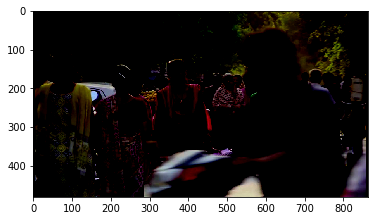

In [38]:
plt.imshow(img/img.max())

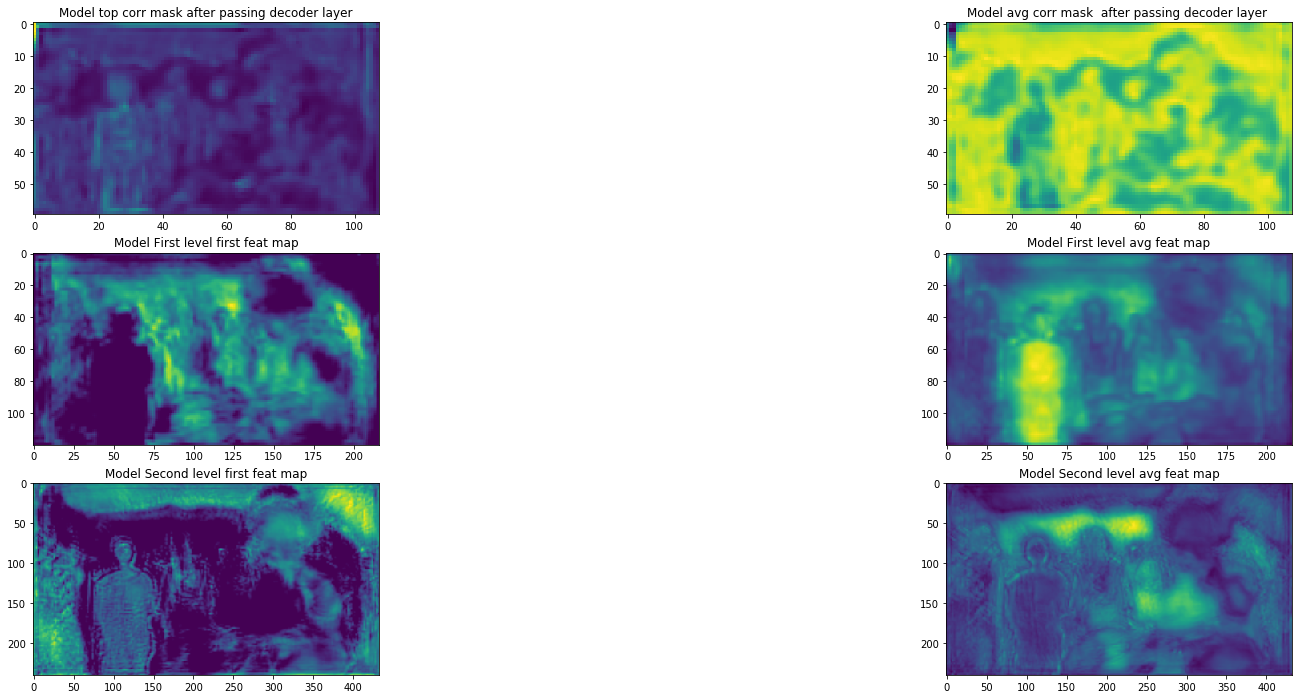

In [42]:
obj = 1
f_id = 0
map1 = corr_f[obj][0][0,f_id].detach().cpu().numpy()
map1_avg = corr_f[obj][0][0].mean(dim=0).detach().cpu().numpy()

f1 = Feat_images_list[0][obj][0][0,0].detach().cpu().numpy()
f1_avg = Feat_images_list[0][obj][0][0,:].mean(dim=0).detach().cpu().numpy()


f2 = Feat_images_list[0][obj][1][0,0].detach().cpu().numpy()
f2_avg = Feat_images_list[0][obj][1][0,:].mean(dim=0).detach().cpu().numpy()

plt.figure(figsize=(30,12))
ax = plt.subplot(3,2,1)
ax.imshow(map1)#, vmin=0, vmax=1)
plt.title("Model top corr mask after passing decoder layer")
ax = plt.subplot(3,2,2)
ax.imshow(map1_avg)#, vmin=0, vmax=1)
plt.title("Model avg corr mask  after passing decoder layer ")

# plt.figure(figsize=(15,12))
ax = plt.subplot(3,2,3)
ax.imshow(f1)#, vmin=0, vmax=1)
plt.title("Model First level first feat map")
ax = plt.subplot(3,2,4)
ax.imshow(f1_avg)#, vmin=0, vmax=1)
plt.title("Model First level avg feat map")
ax = plt.subplot(3,2,5)
ax.imshow(f2)#, vmin=0, vmax=1)
plt.title("Model Second level first feat map")
ax = plt.subplot(3,2,6)
ax.imshow(f2_avg)#, vmin=0, vmax=1)
plt.title("Model Second level avg feat map")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


model 1 best pixel: 68 92
model 2 best pixel: 68 96


Text(0.5, 1.0, 'Template mask')

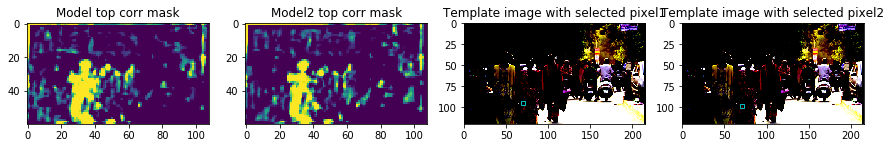

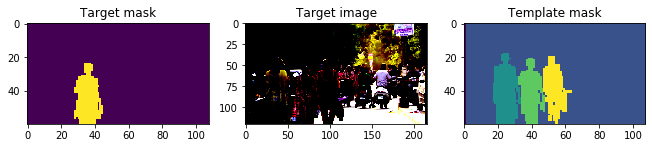

In [66]:
obj = 1
obj_size = [30*4, 54*4]
target_compressed_img = F.interpolate(target,obj_size,\
                                             mode='bilinear', align_corners=True)[0].detach().cpu().numpy()
target_compressed_img = target_compressed_img.transpose(1,2,0)
template_compressed_img = F.interpolate(template,obj_size,\
                                             mode='bilinear', align_corners=True)[0].detach().cpu().numpy()
template_compressed_img = template_compressed_img.transpose(1,2,0)

target_compressed_mask = F.interpolate(target_mask,corr_f[obj][0][0,0].shape[-2:],\
                                             mode='nearest' )[0,0].detach().cpu().numpy()

template_compressed_mask = F.interpolate(template_mask,corr_f[obj][0][0,0].shape[-2:],\
                                             mode='nearest' )[0,0].detach().cpu().numpy()

map1 = corr_f[obj][0][0,0].detach().cpu().numpy()
map1_avg = corr_f[obj][0][0].mean(dim=0).detach().cpu().numpy()
map2 = corr_f2[obj][0][0,0].detach().cpu().numpy()
indexes = corr_f[obj][1]
indexes2 = corr_f2[obj][1]

W,H = corr_f[obj][0][0,0].shape[-2:]
scale = target_compressed_img.shape[-2]//54
x = indexes[0][0][0].item()%(54)
y = indexes[0][0][0].item()//(54)
x = x * scale
y = y * scale
print("model 1 best pixel:", x,y)
rect = patches.Rectangle((x,y),5,5,linewidth=1,edgecolor='c',facecolor='none')

x = indexes2[0][0][0].item()%(54)
y = indexes2[0][0][0].item()//(54)
x = x * scale
y = y * scale
print("model 2 best pixel:", x,y)
rect2 = patches.Rectangle((x,y),5,5,linewidth=1,edgecolor='c',facecolor='none')

plt.figure(figsize=(15,12))

ax = plt.subplot(1,4,1)
ax.imshow(map1, vmin=0, vmax=1)
plt.title("Model top corr mask")
ax = plt.subplot(1,4,2)
ax.imshow(map2, vmin=0, vmax=1)
plt.title("Model2 top corr mask")

ax = plt.subplot(1,4,3)
ax.imshow(template_compressed_img)
ax.add_patch(rect)
plt.title("Template image with selected pixel1")
ax = plt.subplot(1,4,4)
ax.imshow(template_compressed_img)
ax.add_patch(rect2)
plt.title("Template image with selected pixel2")

plt.figure(figsize=(15,12))
ax = plt.subplot(1,4,1)
ax.imshow(target_compressed_mask == obj+2)
plt.title("Target mask")
ax = plt.subplot(1,4,2)
ax.imshow(target_compressed_img)
plt.title("Target image")
ax = plt.subplot(1,4,3)
ax.imshow(template_compressed_mask)
plt.title("Template mask")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'Model avg corr mask unnormalized')

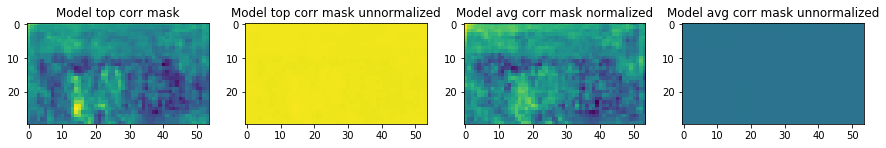

In [32]:
plt.figure(figsize=(15,12))
ax = plt.subplot(1,4,1)
ax.imshow(map1)#, vmin=0, vmax=1)
plt.title("Model top corr mask")
ax = plt.subplot(1,4,2)
ax.imshow(map1, vmin=0, vmax=1)
plt.title("Model top corr mask unnormalized")
ax = plt.subplot(1,4,2)
ax.imshow(map1, vmin=0, vmax=1)
plt.title("Model top corr mask unnormalized")
ax = plt.subplot(1,4,3)
ax.imshow(map1_avg)#, vmin=0, vmax=1)
plt.title("Model avg corr mask normalized")
ax = plt.subplot(1,4,4)
ax.imshow(map1_avg, vmin=0, vmax=1)
plt.title("Model avg corr mask unnormalized")

Text(0.5, 1.0, 'Model top corr mask  after passing decoder layer unnormalized')

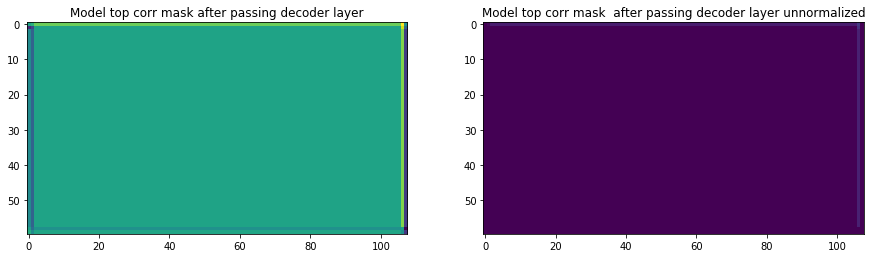

In [41]:
plt.figure(figsize=(15,12))
ax = plt.subplot(1,2,1)
ax.imshow(map1)#, vmin=0, vmax=1)
plt.title("Model top corr mask after passing decoder layer")
ax = plt.subplot(1,2,2)
ax.imshow(map1, vmin=0, vmax=1)
plt.title("Model top corr mask  after passing decoder layer unnormalized")

In [19]:
map1.max()

11.968318